In [1]:
# Importing needed libraries
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, cast, Date

In [5]:
#Creating engine with sqllite db
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflecting existing database into a new model
Base = automap_base()

In [7]:
# preparing engine to reflect
Base.prepare(engine, reflect=True)

In [8]:
# Viewing all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Saving references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
#Checking Columns and types for Measurement table
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
#Checking Columns and types for Station table
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Creating session (link) from Python to the DB
session = Session(engine)

In [13]:
# Testing connection and getting first row for Measurement
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x285f6cfa970>,
 'id': 1,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'prcp': 0.08}

In [14]:
# Testing connection and getting first row for Station
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x285f6d02670>,
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

# Exploratory Climate Analysis

In [15]:
# Retrieving the last 12 months of precipitation data and plot the results

# Calculating the date 1 year ago from the last data point in the database
Last_Data_Point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
for row in Last_Data_Point:
    Last_Date = dt.datetime.strptime(row[:], "%Y-%m-%d")
print(f"Last Reported Date in DB: {Last_Date}")

Last_Year_Date = Last_Date.replace(year = Last_Date.year - 1)
print(f"Date a year before last reported date: {Last_Year_Date}")

# Columns for selection
sel = [Measurement.date
      ,Measurement.prcp]

# Retrieving the data and precipitation scores and saving result in pandas dataframe
Last_Year_Data = session.query(*sel).\
                filter(func.strftime("%Y-%m-%d", Measurement.date) >= Last_Year_Date).\
                order_by(Measurement.date.asc()).all()
Prcp_Data_df = pd.DataFrame(Last_Year_Data, columns=["date","prcp"])

# Indexing date column
Prcp_Data_df = Prcp_Data_df.set_index("date")
print(Prcp_Data_df.head())

# Removing NaN values from data for plot
Prcp_Data_Clean = Prcp_Data_df.dropna()
Prcp_Data_Clean.head()


Last Reported Date in DB: 2017-08-23 00:00:00
Date a year before last reported date: 2016-08-23 00:00:00
            prcp
date            
2016-08-24  0.08
2016-08-24  2.15
2016-08-24  2.28
2016-08-24   NaN
2016-08-24  1.22


,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


(array([-250.,    0.,  250.,  500.,  750., 1000., 1250., 1500., 1750.,
        2000., 2250.]),
 [Text(-250.0, 0, '2017-07-02'),
  Text(0.0, 0, '2016-08-24'),
  Text(250.0, 0, '2016-10-06'),
  Text(500.0, 0, '2016-11-17'),
  Text(750.0, 0, '2017-01-01'),
  Text(1000.0, 0, '2017-02-14'),
  Text(1250.0, 0, '2017-04-01'),
  Text(1500.0, 0, '2017-05-15'),
  Text(1750.0, 0, '2017-06-29'),
  Text(2000.0, 0, '2017-08-19'),
  Text(2250.0, 0, '')])

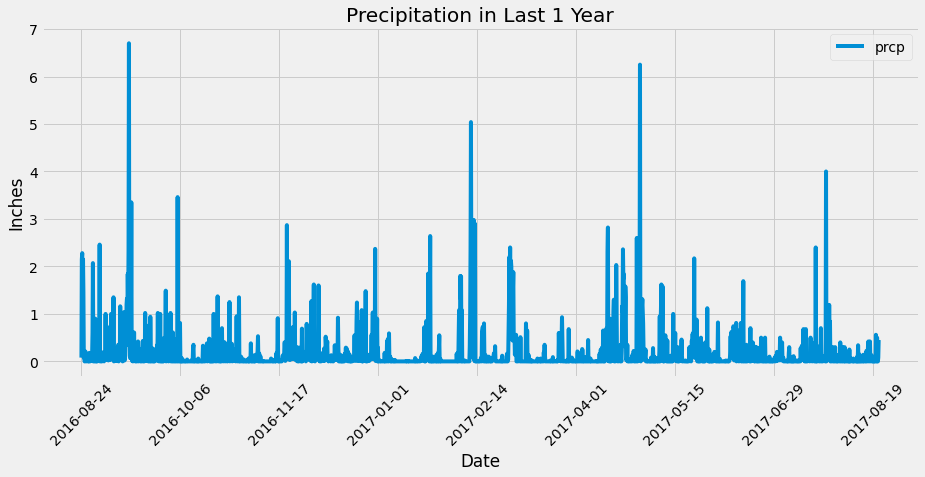

In [16]:
# Plotting Pracipitation data for last 12 months.
prcp_bar = Prcp_Data_Clean.plot(figsize = (14,6))
prcp_bar.set(xlabel = "Date",\
             ylabel = "Inches",\
             title = "Precipitation in Last 1 Year"
            )
plt.xticks(rotation=45)


In [17]:
# Summary statistics for the precipitation data
Prcp_Data_Clean.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Getting number of stations available in datasets
unique_st_count = session.query(Measurement.station).distinct().count()
print(f"Unique Station Count is {unique_st_count}")

Unique Station Count is 9


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

# Columns for selection
sel = [Measurement.station
      ,func.count(Measurement.id)]

st_value_count = session.query(*sel).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.id).desc()).\
                all()
st_value_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Columns for selection
sel = [Measurement.station
       ,func.min(Measurement.tobs)
       ,func.max(Measurement.tobs)
       ,func.avg(Measurement.tobs)
      ]

st_value_count = session.query(*sel).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.id).desc()).\
                first()
st_value_count

('USC00519281', 54.0, 85.0, 71.66378066378067)

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

st_value_count = session.query(Measurement.station).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.tobs).desc()).\
                first()
for row in st_value_count:
    st_max_temp_count = row

print(f"Max Temp Observations are for Station {st_max_temp_count}")
    
# Columns for selection
sel = [Measurement.station
       ,Measurement.date
       ,Measurement.tobs
      ]

# Query to retrieve the Temperature data for the most active station and saving result in pandas dataframe
Last_Year_Temp_Data = session.query(*sel).\
                filter(Measurement.station == st_max_temp_count).\
                filter(func.strftime("%Y-%m-%d", Measurement.date) >= Last_Year_Date).\
                order_by(Measurement.date.asc()).all()
Last_Year_Temp_Data_df = pd.DataFrame(Last_Year_Temp_Data)
Last_Year_Temp_Data_df.head()

Max Temp Observations are for Station USC00519281


,station,date,tobs
0,USC00519281,2016-08-24,77.0
1,USC00519281,2016-08-25,80.0
2,USC00519281,2016-08-26,80.0
3,USC00519281,2016-08-27,75.0
4,USC00519281,2016-08-28,73.0


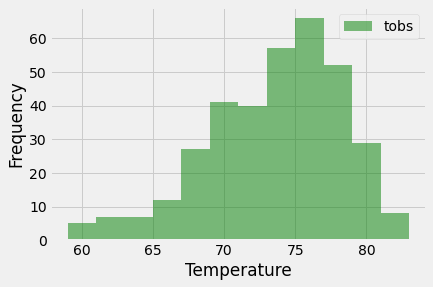

In [22]:
# Plotting the most active station temperature data in histogram
plt.hist(Last_Year_Temp_Data_df["tobs"], 
         bins = 12,
         histtype='bar',
         facecolor='g',
         alpha=0.5
        )
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.show()

## Bonus Challenge Assignment

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
getTemps = calc_temps(Last_Year_Date,Last_Date)
print(getTemps)

[(58.0, 74.57894736842105, 87.0)]


   TMIN       TAVE  TMAX
0  58.0  74.578947  87.0


Text(0.5, 1.0, 'Trip Avg Temp')

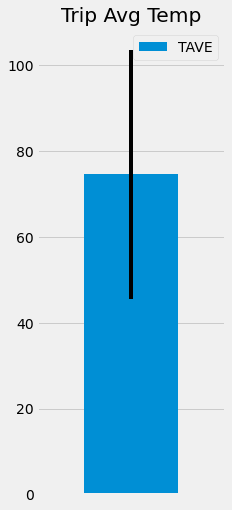

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
getTemps_df = pd.DataFrame(getTemps, columns=["TMIN","TAVE","TMAX"])
print(getTemps_df)
error = getTemps_df["TMAX"]-getTemps_df["TMIN"]
temp_bar = getTemps_df.plot(kind="bar",\
                            y="TAVE",\
                            yerr=error,\
                            figsize = (3,8)
                           )
temp_bar.axes.get_xaxis().set_visible(False)
temp_bar.set_title("Trip Avg Temp")

In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [30]:
# Plot the daily normals as an area plot with `stacked=False`
